In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
%matplotlib inline
# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)
df=pd.read_csv('C:\\house price prediction\\data\\Mumbai House Prices new.csv')
df['LogPrice'] = np.log(df['PRICE in L'])
df.drop("price",axis=1,inplace=True)
df.drop("price_unit",axis=1,inplace=True)
df = pd.get_dummies(df, columns=['type'])
locality_price = df.groupby('locality')['PRICE in L'].mean()
df['locality_encoded'] = df['locality'].map(locality_price)
df['status_encoded'] = df['status'].apply(lambda x: 1 if x == 'Ready to move' else 0)
# Group by locality and calculate the average price
locality_avg_price = df.groupby('locality')['PRICE in L'].mean().reset_index()
# Apply KMeans clustering to localities based on price with a fixed random state
kmeans = KMeans(n_clusters=5, random_state=42)  # Setting a random state for consistency
locality_avg_price['locality_cluster'] = kmeans.fit_predict(locality_avg_price[['PRICE in L']])
# Map clusters back to the original dataframe
df = df.merge(locality_avg_price[['locality', 'locality_cluster']], on='locality', how='left')
df.head(5)

,bhk,locality,area,region,status,age,PRICE in L,LogPrice,type_Apartment,type_Independent House,type_Penthouse,type_Studio Apartment,type_Villa,locality_encoded,status_encoded,locality_cluster
0,3,Lak And Hanware The Residency Tower,685,Andheri West,Ready to move,New,250.00,5.521461,True,False,False,False,False,130.500000,1,0
1,2,Radheya Sai Enclave Building No 2,640,Naigaon East,Under Construction,New,52.51,3.961004,True,False,False,False,False,42.852500,0,0
2,2,Romell Serene,610,Borivali West,Under Construction,New,173.00,5.153292,True,False,False,False,False,207.461538,0,2
3,2,Soundlines Codename Urban Rainforest,876,Panvel,Under Construction,New,59.98,4.094011,True,False,False,False,False,59.980000,0,0
4,2,Origin Oriana,659,Mira Road East,Under Construction,New,94.11,4.544464,True,False,False,False,False,92.480833,0,0


In [17]:
cluster_avg_price = df.groupby('locality_cluster')['PRICE in L'].mean()

sorted_clusters = cluster_avg_price.sort_values()

print("Sorted Average Price per Cluster:")
print(sorted_clusters)
df['PricePerSqFt in L'] = df['PRICE in L'] / df['area']
df['area_x_PricePerSqFt'] = df['area'] * df['PricePerSqFt in L']
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Scaling the numerical features
df[['area']] = scaler.fit_transform(df[['area']])
scaler = StandardScaler()

# Scaling the numerical features
df[['area']] = scaler.fit_transform(df[['area']])

# If you have other numerical features like HouseAge, you can scale them similarly
# df[['HouseAge']] = scaler.fit_transform(df[['HouseAge']])
df.drop("bhk",axis=1,inplace=True)
df.drop("locality_encoded",axis=1,inplace=True)
# df.drop("status_encoded",axis=1,inplace=True)
# Adding interaction feature to the dataset
df['area_PricePerSqFt'] = df['area'] * df['PricePerSqFt in L']

# Update X to include the new feature
X = df[[ 'area', 'locality_cluster', 'PricePerSqFt in L', 'area_PricePerSqFt']]
df.head(5)

Sorted Average Price per Cluster:
locality_cluster
0      89.410085
2     275.389631
1     722.867525
4    1658.511392
3    3476.315789
Name: PRICE in L, dtype: float64


,locality,area,region,status,age,PRICE in L,LogPrice,type_Apartment,type_Independent House,type_Penthouse,type_Studio Apartment,type_Villa,status_encoded,locality_cluster,PricePerSqFt in L,area_x_PricePerSqFt,area_PricePerSqFt
0,Lak And Hanware The Residency Tower,-0.506566,Andheri West,Ready to move,New,250.00,5.521461,True,False,False,False,False,1,0,0.364964,250.00,-0.184878
1,Radheya Sai Enclave Building No 2,-0.573703,Naigaon East,Under Construction,New,52.51,3.961004,True,False,False,False,False,0,0,0.082047,52.51,-0.047071
2,Romell Serene,-0.618461,Borivali West,Under Construction,New,173.00,5.153292,True,False,False,False,False,0,2,0.283607,173.00,-0.175400
3,Soundlines Codename Urban Rainforest,-0.221607,Panvel,Under Construction,New,59.98,4.094011,True,False,False,False,False,0,0,0.068470,59.98,-0.015173
4,Origin Oriana,-0.545356,Mira Road East,Under Construction,New,94.11,4.544464,True,False,False,False,False,0,0,0.142807,94.11,-0.077881


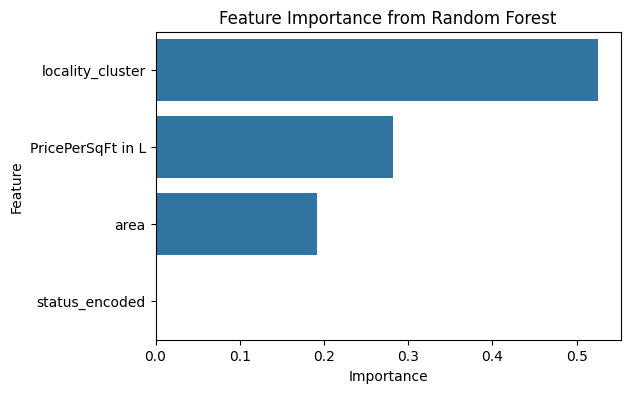

In [4]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Refined feature set
X = df[['area', 'locality_cluster', 'PricePerSqFt in L', 'status_encoded']]
# X = df[['area', 'locality_cluster', 'PricePerSqFt in L', 'area_x_PricePerSqFt']]
y = df['LogPrice']

# Train the Random Forest Regressor
rf = RandomForestRegressor(random_state=42)
rf.fit(X, y)

# Extract feature importances
importances = rf.feature_importances_
features = X.columns

# Create a DataFrame for visualization
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(6,4))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance from Random Forest')
plt.show()


# Phase 7: Model Interpretation (2 Days)
Feature Importance:

we have already explored feature importance from Random Forest. Let’s expand this by using SHAP (SHapley Additive exPlanations), which provides detailed insights into how each feature impacts individual predictions.
Here's how we can calculate SHAP values:

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training the Random Forest model on the training set
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

# Making predictions on the test set
y_pred_test = rf.predict(X_test)

# Evaluate the model on the test set
mae_test = mean_absolute_error(y_test, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_test = r2_score(y_test, y_pred_test)

print(f"Test MAE: {mae_test}")
print(f"Test RMSE: {rmse_test}")
print(f"Test R² Score: {r2_test}")
print(X_train.shape)
print(y_train.shape)



Test MAE: 0.002614854869206781
Test RMSE: 0.011161864653776297
Test R² Score: 0.9998236358780475
(60830, 4)
(60830,)


In [19]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

# Define the hyperparameters and their ranges for Randomized Search
param_distributions = {
    'n_estimators': [100, 200, 500, 1000],
    'max_depth': [None, 10, 20, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize the Random Forest model
rf = RandomForestRegressor(random_state=42)

# Perform Randomized Search with 5-fold cross-validation
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_distributions,
    n_iter=50,  # Number of parameter settings sampled
    cv=5,  # 5-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit the RandomizedSearchCV
random_search.fit(X_train, y_train)

# Get the best parameters from the search
best_params = random_search.best_params_
print(f"Best Hyperparameters: {best_params}")

# Re-train the model with the best parameters
rf_best = RandomForestRegressor(**best_params, random_state=42)
rf_best.fit(X_train, y_train)

# Test the model on the test set
y_pred_best = rf_best.predict(X_test)

# Evaluate the model with the optimized hyperparameters
mae_best = mean_absolute_error(y_test, y_pred_best)
rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
r2_best = r2_score(y_test, y_pred_best)

print(f"Tuned Test MAE: {mae_best}")
print(f"Tuned Test RMSE: {rmse_best}")
print(f"Tuned Test R² Score: {r2_best}")
print(rf_best)


Fitting 5 folds for each of 50 candidates, totalling 250 fits


KeyboardInterrupt: 

In [20]:
import shap
from sklearn.ensemble import RandomForestClassifier

# Example: Train a Random Forest classifier
rf_best = RandomForestClassifier(n_estimators=100, random_state=42)
rf_best.fit(X_train, y_train)  # Use your training data (X_train and y_train)

# Train SHAP explainer on your tuned Random Forest model
explainer = shap.TreeExplainer(rf_best)
shap_values = explainer(X_test)  # Update this line

# Plot SHAP summary
shap.summary_plot(shap_values, X_test)


ValueError: Unknown label type: continuous. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

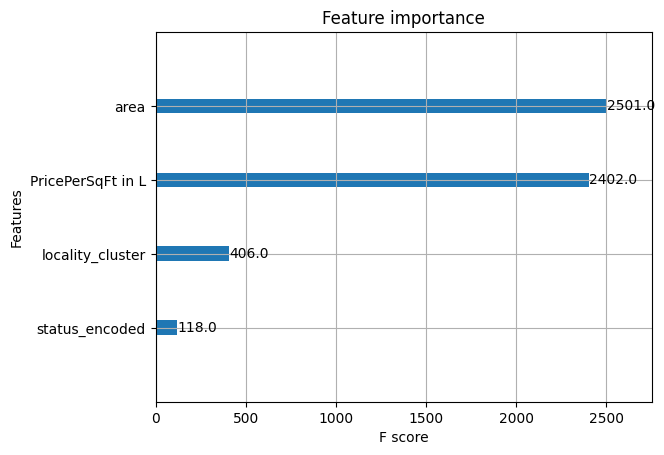

In [12]:
import xgboost as xgb
model = xgb.XGBRegressor()
model.fit(X_train, y_train)

xgb.plot_importance(model)